In [132]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_png
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        """
            data: scalar data
            _children: records the parents of the node.
            _op: Denotes the operation performed to get the output from its parents.
        """

        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # _prev is a set of tuples for optimization purpose.
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+") # for the variable `out` self and other are the parents.
        
        def _backward():
            # self.grad = 1.0 * out.grad
            # other.grad = 1.0 * out.grad

            # The gradients are accumulated to avoid overwritting of gradient when the same variables are used multiple times.
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*") # for the variable `out` self and other are the parents.

        def _backward():
            # self.grad = other.data * out.grad
            # other.grad = self.data * out.grad

            # The gradients are accumulated to avoid overwritting of gradient when the same variables are used multiple times.
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            x = self.data
            self.grad += (4*np.exp(2*x)) / ((np.exp(2*x) + 1) ** 2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)

                topo.append(node)
        
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [146]:
a = Value(20.0, label="a")
b = Value(-100.0, label="b")
c = Value(4.0, label="c")

d = a*b

e = d + c

d.label = "d"
e.label = "e"

In [147]:
print(d._prev) # The parents are a*b and c
print(d._op)

{Value(data=20.0), Value(data=-100.0)}
*


In [157]:
# A vanilla NN

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.881, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

## Viz the neural graph

In [136]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
            
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        
        # Create the data node for this node.
        dot.node(name=uid, label= "{%s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape="record")

        
        if n._op:
            # If this node is a result of some operation create an operator node that precedes it.
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



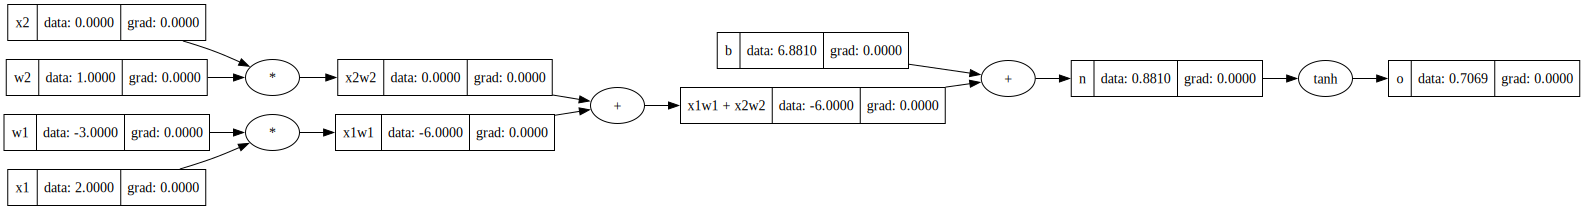

In [153]:
draw_dot(o)

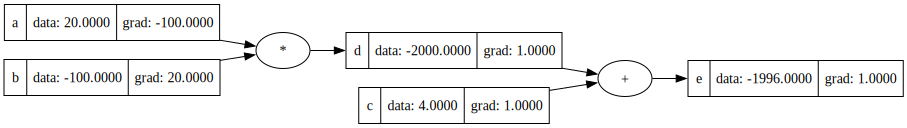

In [154]:
draw_dot(e)

## Topological Sort

In [107]:
visited = set()
topo = []
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    
    return topo

### Apply Recursive backward function in the topological order

In [108]:
topo_order = build_topo(e)

In [109]:
topo_order

[Value(data=-100.0),
 Value(data=20.0),
 Value(data=-2000.0),
 Value(data=4.0),
 Value(data=-1996.0)]

In [110]:
def backprop(topo_order: list):

    topo_order[-1].grad = 1.0

    for node in reversed(topo_order):
        node._backward()

    dot = draw_dot(topo_order[-1])
    display_png(dot)

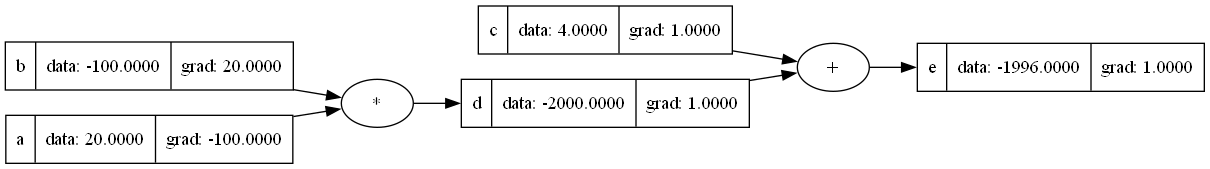

In [113]:
backprop(topo_order)

## Apply Backpropagation using Value class

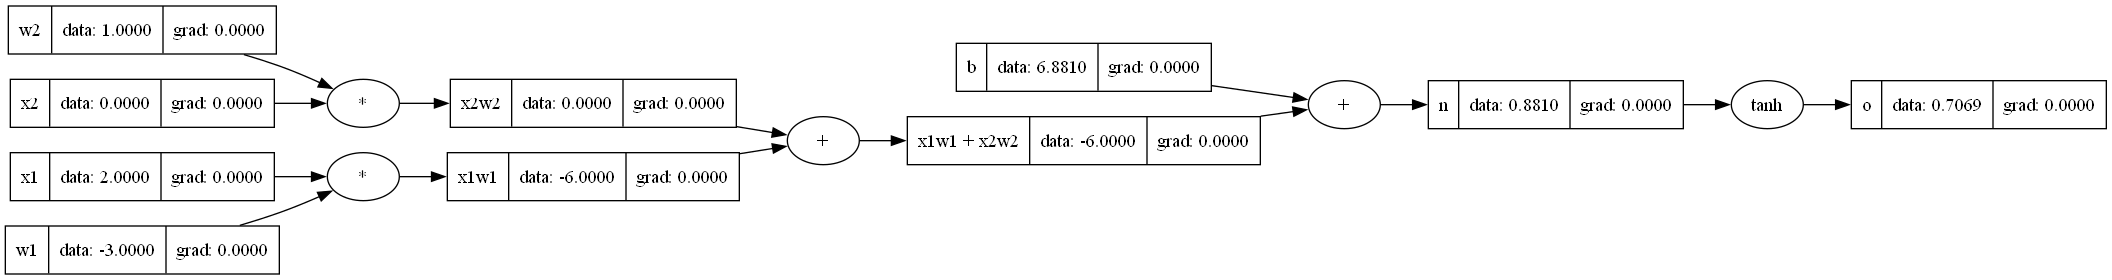

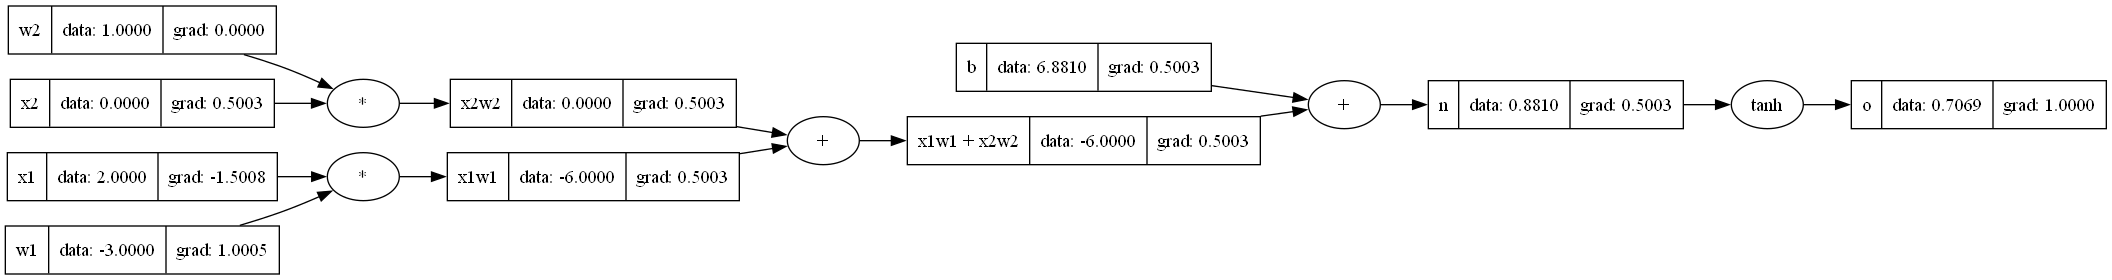

In [158]:
# End output => o

display_png(draw_dot(o)) # Before grad calculation
o.backward()
display_png(draw_dot(o)) # After grad calculation

In [159]:
# Things to do.

# Accumulate gradient
# Further decompose the tanh operation into simpler ones. 